# Scientific Initiation Project About Classifying Pinus Taeda Using Satelite Images
This work has as objective monitoring the spreading of Pinus Taeda on Ponta Grossa using Machine Learning algorithms applied on satelite images. In the next cells, I'll explain my code and thinking about the problem.

## 1. Libraries

In [52]:
import os
import random
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import scipy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

## 2. Importing Data

In [38]:
# Define paths
main_folder = '/home/shuruyi/Documents/qgis/google_satelite/extracted_images/'
train = '/home/shuruyi/Documents/qgis/google_satelite/train'
valid = '/home/shuruyi/Documents/qgis/google_satelite/validation'
test = '/home/shuruyi/Documents/qgis/google_satelite/test'

# Create train, validation, and test directories if they don't exist
os.makedirs(train, exist_ok=True)
os.makedirs(valid, exist_ok=True)
os.makedirs(test, exist_ok=True)

# List all TIFF files in the main folder
tif_files = [f for f in os.listdir(main_folder) if f.endswith('.tif')]

if not tif_files:
    # If main folder is empty, use the other folders
    train_files = [f for f in os.listdir(os.path.join(train, 'not-pinus')) if f.endswith('.tif')]
    train_files += [f for f in os.listdir(os.path.join(train, 'pinus')) if f.endswith('.tif')]
    valid_files = [f for f in os.listdir(os.path.join(valid, 'not-pinus')) if f.endswith('.tif')]
    valid_files += [f for f in os.listdir(os.path.join(valid, 'pinus')) if f.endswith('.tif')]
    test_files = [f for f in os.listdir(os.path.join(test)) if f.endswith('.tif')]
else:
    # Define the ratio for train-validation-test split (e.g., 70-20-10 split)
    train_ratio = 0.7
    valid_ratio = 0.2
    test_ratio = 1 - train_ratio - valid_ratio

    # Randomly shuffle the list of files
    random.shuffle(tif_files)

    # Split the data into train, validation, and test sets
    train_files, test_files = train_test_split(tif_files, test_size=test_ratio, random_state=42)
    train_files, valid_files = train_test_split(train_files, test_size=valid_ratio / (train_ratio + valid_ratio),
                                                random_state=42)

    # Move files to train, validation, and test folders
    for file in train_files:
        src = os.path.join(main_folder, file)
        # Extract label from the filename
        label = int(file.split('_label_')[-1].split('.')[0])
        if label == 0:
            dst = os.path.join(train, 'not-pinus', file)
        else:
            dst = os.path.join(train, 'pinus', file)
        shutil.move(src, dst)

    for file in valid_files:
        src = os.path.join(main_folder, file)
        # Extract label from the filename
        label = int(file.split('_label_')[-1].split('.')[0])
        if label == 0:
            dst = os.path.join(valid, 'not-pinus', file)
        else:
            dst = os.path.join(valid, 'pinus', file)
        shutil.move(src, dst)

    for file in test_files:
        src = os.path.join(main_folder, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)
        
# Convert lists to DataFrames
train_df = pd.DataFrame(train_files, columns=['file_path'])
valid_df = pd.DataFrame(valid_files, columns=['file_path'])
test_df = pd.DataFrame(test_files, columns=['file_path'])

# Display the DataFrames
print("Train DataFrame:")
print(train_df.sample(5))
print("\nValidation DataFrame:")
print(valid_df.sample(5))
print("\nTest DataFrame:")
print(test_df.sample(5))

Train DataFrame:
                           file_path
967    extracted_roi_443_label_1.tif
1321   extracted_roi_300_label_1.tif
1276  extracted_roi_1154_label_1.tif
332    extracted_roi_228_label_0.tif
443    extracted_roi_267_label_0.tif

Validation DataFrame:
                         file_path
36   extracted_roi_827_label_0.tif
96   extracted_roi_237_label_0.tif
103  extracted_roi_993_label_0.tif
129  extracted_roi_313_label_0.tif
494  extracted_roi_944_label_1.tif

Test DataFrame:
                         file_path
200  extracted_roi_902_label_1.tif
82   extracted_roi_386_label_1.tif
43   extracted_roi_140_label_0.tif
65   extracted_roi_350_label_0.tif
131  extracted_roi_447_label_1.tif


In [31]:
# Store the test_df on a pdf with the true labels

# Path to csv
csv_filepath = '/home/shuruyi/Documents/qgis/google_satelite/test_labels.csv'

# Extract labels from file names
test_labels = [int(file.split('_label_')[-1].split('.')[0]) for file in test_files]

# Add the column label to the test_df
test_df['labels'] = test_labels

test_df

if not os.path.isfile(csv_filepath):
    # Define the file path where you want to save the CSV fil
    test_df.to_csv(csv_filepath, index=False)
    print("CSV saved sucessfully")
else:
    print("CSV already on the directory.")

CSV saved sucessfully


## 3. Trainning the model

In [5]:
# CNN model parameters
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
epochs = 14
batch_size = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Assuming 'train', 'valid', and 'test' are paths to the directories containing respective data
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Print training and validation loss and accuracy
print("Training Loss:", history.history['loss'])
print("Training Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

Found 1774 images belonging to 2 classes.


Found 507 images belonging to 2 classes.
Epoch 1/14
56/56 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.7582

/home/shuruyi/Documents/git/IC/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 308s 5s/step - loss: 0.5009 - accuracy: 0.7582 - val_loss: 0.3602 - val_accuracy: 0.8521
Epoch 2/14
56/56 [==============================] - 294s 5s/step - loss: 0.3646 - accuracy: 0.8439 - val_loss: 0.3323 - val_accuracy: 0.8833
Epoch 3/14
56/56 [==============================] - 281s 5s/step - loss: 0.3232 - accuracy: 0.8630 - val_loss: 0.2908 - val_accuracy: 0.8604
Epoch 4/14
56/56 [==============================] - 270s 5s/step - loss: 0.2824 - accuracy: 0.8811 - val_loss: 0.2071 - val_accuracy: 0.9208
Epoch 5/14
56/56 [==============================] - 268s 5s/step - loss: 0.2854 - accuracy: 0.8850 - val_loss: 0.3743 - val_accuracy: 0.8229
Epoch 6/14
56/56 [==============================] - 273s 5s/step - loss: 0.2523 - accuracy: 0.8952 - val_loss: 0.1952 - val_accuracy: 0.9271
Epoch 7/14
56/56 [==============================] - 413s 7s/step - loss: 0.2311 - accuracy: 0.9087 - val_loss: 0.2420 - val_accuracy: 0.8896
Epoch 8/14
56/56 [======

## 4. Loading a Save Model

In [ ]:
# Load the model
model = load_model('/content/drive/MyDrive/IC/best_model.h5')

In [ ]:
# Verify the model
print(model.summary())

## 5. Making Predictions

In [34]:
# Get list of all .tif files in the test folder
test_image_files = [os.path.join(test, f) for f in os.listdir(test) if f.endswith('.tif')]

# Prepare data for testing
test_images = []
for image_path in test_image_files:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    test_images.append(img)

# Convert the list of images to numpy array
test_images = np.array(test_images)

# Get predictions for the test data
predictions = model.predict(test_images)

# Convert probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Create a DataFrame for binary predictions
binary_predictions_df = pd.DataFrame(binary_predictions, columns=['binary_predictions'])
binary_predictions_df

# Concatenate test_df file names with binary_predictions
pred_df = pd.concat([test_df.file_path, binary_predictions_df], axis=1)

# Print the pred_df
pred_df

8/8 [==============================] - 1s 81ms/step


,file_path,binary_predictions
0,extracted_roi_196_label_1.tif,1
1,extracted_roi_1163_label_1.tif,1
2,extracted_roi_1084_label_1.tif,1
3,extracted_roi_741_label_0.tif,0
4,extracted_roi_1048_label_0.tif,0
...,...,...
249,extracted_roi_1231_label_1.tif,1
250,extracted_roi_870_label_0.tif,0
251,extracted_roi_1117_label_0.tif,0
252,extracted_roi_827_label_1.tif,1


## 6. Results

In [36]:
# Assuming true labels are stored in a variable called true_labels
true_labels = test_df['labels'].values  # Extracting true labels from the DataFrame

# Assuming predicted binary values are in the concatenated_df DataFrame under 'Binary_Predictions' column
predicted_values = pred_df['binary_predictions'].values  # Extracting predicted binary values

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(true_labels, predicted_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.09%


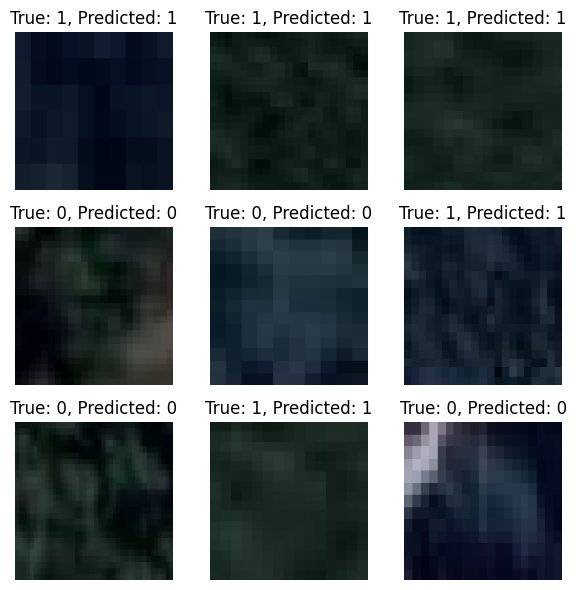

In [42]:
# Assuming 'test_image_files' contains the file paths of test images
# Assuming 'binary_predictions' contains the binary predictions for the test images

# Define a function to plot images with labels
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(6, 6))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and plot a sample of test images with true and predicted labels
sample_size = min(9, len(test_images))  # Adjust the sample size if needed
sample_images = test_images[:sample_size]
sample_true_labels = true_labels[:sample_size]  # Assuming true_labels is defined
sample_predicted_labels = binary_predictions.flatten()[:sample_size]

plot_images(sample_images, sample_true_labels, sample_predicted_labels)

Length of true_labels: 254
Length of binary_predictions: 254
Incorrect indices: [46, 72, 75, 116, 119, 134, 144, 155, 156, 159, 162, 169, 182, 200, 233]


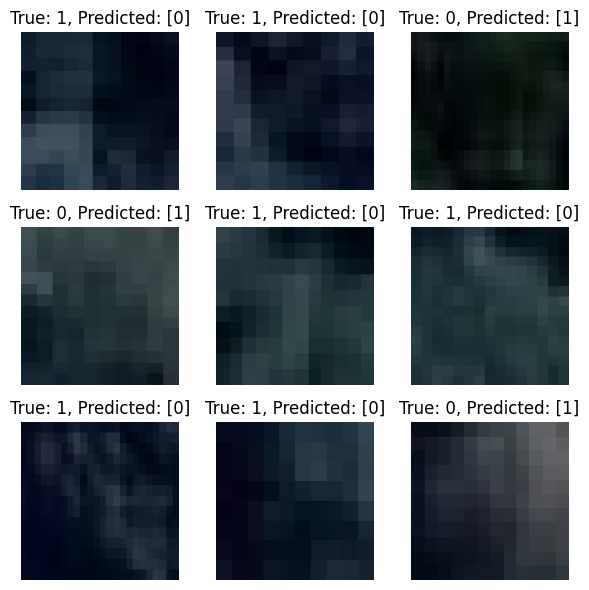

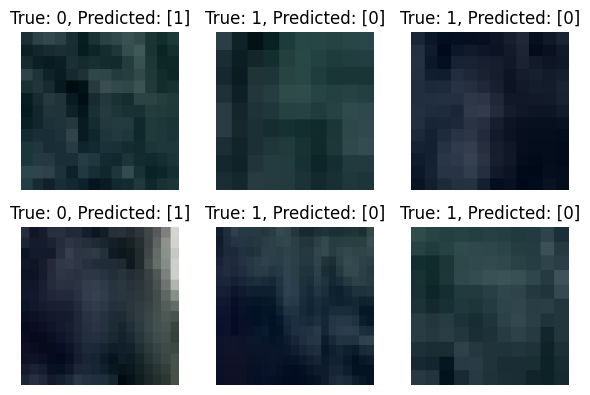

In [51]:
# Assuming 'test_image_files' contains the file paths of test images
# Assuming 'true_labels' contains the true labels for the test images
# Assuming 'binary_predictions' contains the binary predictions for the test images

# Print the lengths of the lists for debugging
print("Length of true_labels:", len(true_labels))
print("Length of binary_predictions:", len(binary_predictions))

# Identify indices of images with incorrect predictions
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != binary_predictions[i]]
print("Incorrect indices:", incorrect_indices)  # Print the incorrect indices for debugging

# Define a function to plot images with labels
def plot_incorrect_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(6, 6))
    for i in range(len(images)):
        plt.subplot(3, 3, i % 9 + 1)  # Adjusted subplot indices to fit within 1-9
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.axis('off')
        if (i + 1) % 9 == 0 or i == len(images) - 1:  # Break after plotting 9 images or at the end of the list
            plt.tight_layout()
            plt.show()
            if i != len(images) - 1:  # Start a new figure if there are more images to plot
                plt.figure(figsize=(6, 6))

# Get images with incorrect predictions
incorrect_images = [test_images[idx] for idx in incorrect_indices]
incorrect_true_labels = [true_labels[idx] for idx in incorrect_indices]
incorrect_predicted_labels = [binary_predictions[idx] for idx in incorrect_indices]

# Plot images with incorrect predictions
plot_incorrect_images(incorrect_images, incorrect_true_labels, incorrect_predicted_labels)

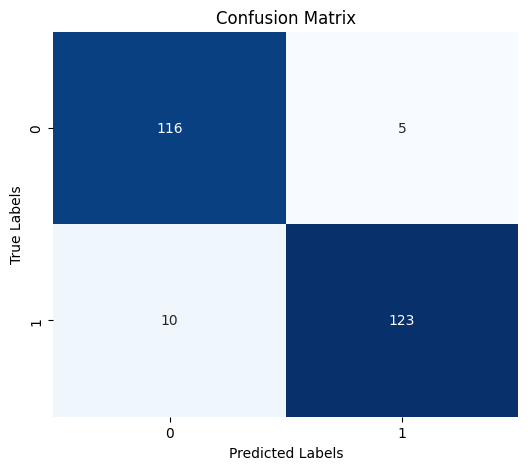

In [37]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_values)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()